## MAP FORM

## Poisson Regression of NINO3.4, MDR SSTA, and QBO

#### Import packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,
    Independence,Autoregressive)
from statsmodels.genmod.families import Poisson

In [2]:
#!conda install statsmodels

#### Read in data from netCDF

In [3]:
ds = xr.open_dataset('/data/jennie/Pobs_start_season_1950_2016.nc')

In [4]:
dMDR=xr.open_dataset('/data/jennie/Pkaplan_MDR_season_1950_2016.nc')

In [5]:
MDR=dMDR.MDR.values

In [6]:
a=len(MDR)

In [7]:
dNINO3p4=xr.open_dataset('/data/jennie/Pkaplan_NINO3p4_season_1950_2016.nc')

In [8]:
NINO3p4=dNINO3p4.NINO3p4.values

In [9]:
dQBO=xr.open_dataset('/data/jennie/Pncep_QBO30mb_season_1950_2016.nc')

In [10]:
QBO=dQBO.QBO.values

In [11]:
subject= np.ones(a)

In [12]:
fam = Poisson()
ind = Independence()

In [13]:
# define a function to compute a multiregr of a timeseries
def multiregr(x):
    starts1a=x.starts.values
    data = {'starts': starts1a,
        'MDR': MDR,
        'NINO3p4': NINO3p4,
         'QBO': QBO,'subject': subject}
    y = list(range(0,a))
    df = pd.DataFrame(data, index=[y])
    model1 = GEE.from_formula("starts ~ MDR + NINO3p4 + QBO", "subject", df, cov_struct=ind, family=fam)
    result1 = model1.fit()
    pMDR=result1.params.MDR
    pNINO3p4=result1.params.NINO3p4
    pQBO=result1.params.QBO
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(pMDR)

In [14]:
# apply the function over allpoints to calculate the regression at each point
stacked = ds.stack(allpoints=['Y','X'])  
coeff = stacked.groupby('allpoints').apply(multiregr)
stacked

/home/jennie/miniconda3/envs/pangeo/lib/python3.6/site-packages/statsmodels/genmod/cov_struct.py:203: RuntimeWarning: invalid value encountered in true_divide
  rslt.append(x / v[:, None])
/home/jennie/miniconda3/envs/pangeo/lib/python3.6/site-packages/statsmodels/genmod/cov_struct.py:201: RuntimeWarning: invalid value encountered in true_divide
  rslt.append(x / v)


<xarray.Dataset>
Dimensions:    (allpoints: 1012, time: 67)
Coordinates:
  * time       (time) datetime64[ns] 1950-07-02T12:00:00 1951-07-02T12:00:00 ...
  * allpoints  (allpoints) MultiIndex
  - Y          (allpoints) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 ...
  - X          (allpoints) float64 -100.0 -98.0 -96.0 -94.0 -92.0 -90.0 ...
Data variables:
    starts     (time, allpoints) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

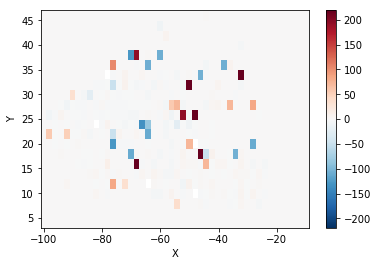

In [15]:
regr_unstacked = coeff.unstack('allpoints')
regr_unstacked.plot(cmap='RdBu_r')

In [16]:
plt.savefig('seasonMDRrawplot.jpeg')

<Figure size 432x288 with 0 Axes>

In [17]:
import sys
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import xarray as xr

from cartopy import config
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature 
# When data are defined in lat/lon coordinate system, PlateCarree()
# is the appropriate choice:

from cartopy.util import add_cyclic_point

In [18]:
regr_unstacked

<xarray.DataArray (Y: 22, X: 46)>
array([[1.476338e-17, 1.476338e-17, 1.476338e-17, ..., 1.476338e-17,
        1.476338e-17, 1.476338e-17],
       [1.476338e-17, 1.476338e-17, 1.476338e-17, ..., 1.476338e-17,
        1.476338e-17, 1.476338e-17],
       [1.476338e-17, 1.476338e-17, 1.476338e-17, ..., 1.476338e-17,
        1.476338e-17, 1.476338e-17],
       ...,
       [1.476338e-17, 1.476338e-17, 1.476338e-17, ..., 1.476338e-17,
        1.476338e-17, 1.476338e-17],
       [1.476338e-17, 1.476338e-17, 1.476338e-17, ..., 1.476338e-17,
        1.476338e-17, 1.476338e-17],
       [1.476338e-17, 1.476338e-17, 1.476338e-17, ..., 1.476338e-17,
        1.476338e-17, 1.476338e-17]])
Coordinates:
  * Y        (Y) float64 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 ...
  * X        (X) float64 -100.0 -98.0 -96.0 -94.0 -92.0 -90.0 -88.0 -86.0 ...

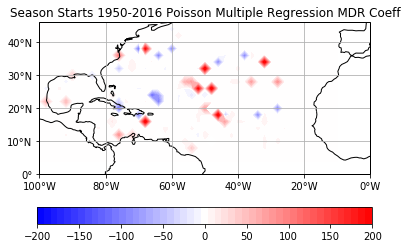

In [19]:
X=ds.X
Y=ds.Y
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
v = np.linspace(-200, 200, 50, endpoint=True)
vv = np.linspace(-200, 200, 9, endpoint=True)
im=plt.contourf(X, Y, regr_unstacked, v,
             transform=ccrs.PlateCarree(), cmap = "bwr")
cb = plt.colorbar(im, ticks=vv, orientation='horizontal', shrink = 1, label='')
ax.coastlines()
ax.set_xticks([-100, -80 ,-60, -40, -20, 0], crs=ccrs.PlateCarree())
ax.set_yticks([0, 10, 20, 30, 40], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.gridlines(xlocs=[-100, -80 ,-60, -40, -20, 0], ylocs=[0, 10, 20, 30, 40, 50])
plt.title('Season Starts 1950-2016 Poisson Multiple Regression MDR Coeff', fontsize=12)
plt.savefig('MDR50.jpeg')
plt.show()